# Exercise 8: Put all the concepts in Exercise 7 together

Skills:
* Apply all the concepts covered in Exercise 7 for a research question. Know when to use what concept.

References: 
* Exercise 7


### To Do

Narrow down the list of rail routes in CA to 3 groups. Use the SHN network to determine how much of the rail route runs near the SHN. We care only about rail routes that run entirely in CA (use stops to figure this out).

**Near** the interstate, US highway, or state highway is defined by being within a quarter mile. For this exercise, the distinction between interstate, US highway, and state highway is not important; treat any road that shows up in the dataset as "the SHN".

There are theoretically 3 groupings: 
* rail routes that are never within 0.25 miles of the SHN (>0.25
* rail routes with > 0 but less than half of its length near the SHN (0<x<0.5)
* rail routes with at least half of its length near the SHN(

Provide a table and a chart showing how many rail routes fall into each of the 3 groups by district.

Use a Markdown cell at the end to connect which geospatial concept was applied to which step of the process. The concepts that should be used are `projecting CRS`, `buffering`, `dissolve`, `clipping`, `spatial join`, `overlay`. 

---
---
## Notes
* all imported dfs are gdf 
* all with CRS 4326 (decimal degrees)
* all with active geometry col set to `geometry`
* all gdf filtered down to rail groups 0, 1 and 2
* geometry type for each gdf
    1. districts - polygon
    2. ca_highways - multi line string 
    3. routes - line string
    4. rail_routes - line string
    5. stops - point
    6. rail_stops - point
* check the plots of all the gdfs
* gdf not in CA
    1. routes (nationwide)
    2. rail routes (nationwide)
    3. stops 
    4. rail stops 
---
## Cleaning

* COMPLETE project all gdf to "EPSG:2229" to get everything in feet
* COMPELTE subset/filter all gdf to California only
    1. dissolve districts map to be CA only.
    2. clip the other gdf to CA map. 
        `ca` - California polygon
        
        `ca_routes` - transit routes in CA
        
        `ca_rail` - rail routes in CA for 0,1,2
        
        `ca_stops` - transit stops in CA
        
        `ca_rail_stops` - rail stops in CA for 0,1,2

* prepare gdfs needed
    1. COMPLETE buffer rail routes to 1320ft (.25miles)
        `ca_rail_buffer`
        
---


## Breakdown of steps

    

### Use the SHN network to determine how much of the rail route runs near the SHN (<.25 miles)
   * need: 
       1. `ca_rail_buffer`
       2. `ca highway` 
       3. `district`

   * steps:
       1. create a GDF that combines the geomtry cols of the 3 gdf
       Or make a join of 2 gdf, then overlay the 3rd?
       overlay is for intersecting layers?
    
### rail routes that are never within 0.25 miles of the SHN
    * need:
        1. buffered route map
        

### rail routes with > 0 but less than half of its length near the SHN
    1. buffered rail route to < half_len

### rail routes with at least half of its length near the SHN
    1. buffered rail route to >= half_len
---
---

In [1]:
import geopandas as gpd
import intake
import pandas as pd

catalog = intake.open_catalog(
    "../_shared_utils/shared_utils/shared_data_catalog.yml")

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
/tmp/ipykernel_615/1769798718.py:1: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS directly (calling P

In [32]:
# Import data
districts = catalog.caltrans_districts.read()
ca_highways = catalog.state_highway_network.read()

rail_group = ['0', '1', '2']
routes = catalog.ca_transit_routes.read()
rail_routes = routes[routes.route_type.isin(rail_group)
                    ].reset_index(drop=True)

stops = catalog.ca_transit_stops.read()
rail_stops = stops[stops.route_type.isin(rail_group)
                  ].reset_index(drop=True)

---

## Geodataframe checks

---

In [3]:
#checked the CRS for all imported data, they all have EPSG: 4326

# districts.crs, highways.crs, routes.crs, rail_routes.crs, stops.crs, rail_stops.crs

In [152]:
#function test

def gdf_check(gdf):(
    print(f'Dataframe type is = {type(gdf)}'),
    print(f'GDF shape is = {gdf.shape}'),
    print(f'Active geometry col name is = {gdf.geometry.name}'),
    display(gdf.head()),
    display(gdf.plot())
    )

Dataframe type is = <class 'geopandas.geodataframe.GeoDataFrame'>
gdf shape is = (12, 6)
Active geometry col name is = geometry


,OBJECTID,DISTRICT,Region,Shape__Area,Shape__Length,geometry
0,1,1,North,4.659910e+10,1.644579e+06,"POLYGON ((-123.51781 42.00076, -123.51793 42.0..."
1,2,2,North,1.266950e+11,1.775639e+06,"POLYGON ((-122.30409 42.00835, -122.34369 42.0..."
2,3,3,North,5.458748e+10,1.468290e+06,"POLYGON ((-121.40482 40.13005, -121.40482 40.1..."
3,4,4,,3.383387e+10,1.291122e+06,"POLYGON ((-122.38960 38.85632, -122.38980 38.8..."
4,5,5,Central,4.853090e+10,1.380598e+06,"POLYGON ((-121.21407 36.95981, -121.21906 36.9..."


<AxesSubplot:>

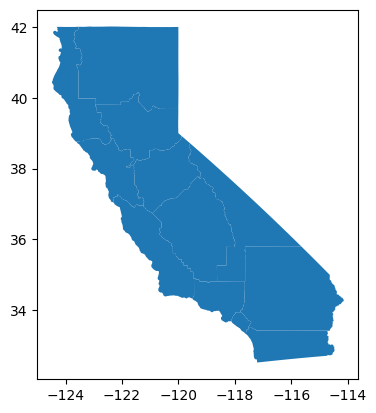

In [153]:
gdf_check(districts)

Dataframe type is = <class 'geopandas.geodataframe.GeoDataFrame'>
gdf shape is = (12, 6)
Active geometry col name is = geometry


,OBJECTID,DISTRICT,Region,Shape__Area,Shape__Length,geometry
0,1,1,North,4.659910e+10,1.644579e+06,"POLYGON ((-123.51781 42.00076, -123.51793 42.0..."
1,2,2,North,1.266950e+11,1.775639e+06,"POLYGON ((-122.30409 42.00835, -122.34369 42.0..."
2,3,3,North,5.458748e+10,1.468290e+06,"POLYGON ((-121.40482 40.13005, -121.40482 40.1..."
3,4,4,,3.383387e+10,1.291122e+06,"POLYGON ((-122.38960 38.85632, -122.38980 38.8..."
4,5,5,Central,4.853090e+10,1.380598e+06,"POLYGON ((-121.21407 36.95981, -121.21906 36.9..."


<AxesSubplot:>

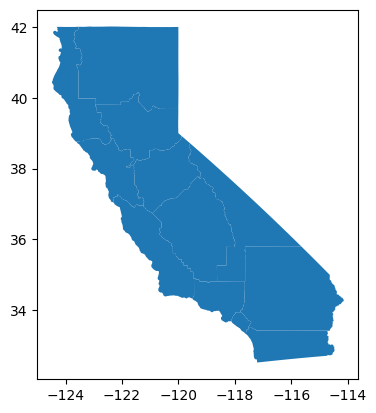

In [154]:
#gdf of caltrans districts

gdf_check(districts)

Dataframe type is = <class 'geopandas.geodataframe.GeoDataFrame'>
gdf shape is = (1052, 6)
Active geometry col name is = geometry


,Route,County,District,RouteType,Direction,geometry
0,1,LA,7,State,NB,"MULTILINESTRING ((-118.14322 33.79010, -118.14..."
1,1,LA,7,State,SB,"MULTILINESTRING ((-118.39630 33.94454, -118.39..."
2,1,MEN,1,State,NB,"MULTILINESTRING ((-123.81956 39.79816, -123.81..."
3,1,MEN,1,State,SB,"MULTILINESTRING ((-123.79591 39.69252, -123.79..."
4,1,MON,5,State,NB,"MULTILINESTRING ((-121.76641 36.77189, -121.76..."


<AxesSubplot:>

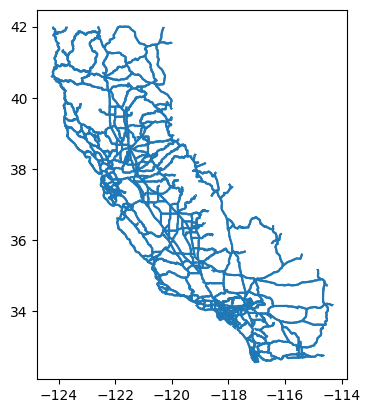

In [155]:
#gdf of CA highways

gdf_check(ca_highways)

In [8]:
rail_group

['0', '1', '2']

Dataframe type is = <class 'geopandas.geodataframe.GeoDataFrame'>
gdf shape is = (7161, 10)
Active geometry col name is = geometry


,org_id,agency,route_id,route_type,route_name,shape_id,n_trips,base64_url,uri,geometry
0,recNaKvzVQhGX1puu,City of Alhambra,BlueLine,3,Blue Line,p_901543,17,aHR0cHM6Ly9naXRodWIuY29tL0xBQ01UQS9sb3MtYW5nZW...,https://github.com/LACMTA/los-angeles-regional...,"LINESTRING (-118.16836 34.06329, -118.16895 34..."
1,recNaKvzVQhGX1puu,City of Alhambra,BlueLine,3,Blue Line,p_901544,18,aHR0cHM6Ly9naXRodWIuY29tL0xBQ01UQS9sb3MtYW5nZW...,https://github.com/LACMTA/los-angeles-regional...,"LINESTRING (-118.12344 34.09633, -118.12347 34..."
2,recNaKvzVQhGX1puu,City of Alhambra,GreenLine,3,Green Line,p_901545,33,aHR0cHM6Ly9naXRodWIuY29tL0xBQ01UQS9sb3MtYW5nZW...,https://github.com/LACMTA/los-angeles-regional...,"LINESTRING (-118.11131 34.07941, -118.11131 34..."
3,recNaKvzVQhGX1puu,City of Alhambra,GreenLine,3,Green Line,p_901546,33,aHR0cHM6Ly9naXRodWIuY29tL0xBQ01UQS9sb3MtYW5nZW...,https://github.com/LACMTA/los-angeles-regional...,"LINESTRING (-118.11159 34.07916, -118.11175 34..."
4,recSBFiK95hJnJuYx,Amador Regional Transit System,569,3,Sacramento,p_859,2,aHR0cHM6Ly9kYXRhLnRyaWxsaXVtdHJhbnNpdC5jb20vZ3...,https://data.trilliumtransit.com/gtfs/amador-c...,"LINESTRING (-120.80805 38.38005, -120.80799 38..."


<AxesSubplot:>

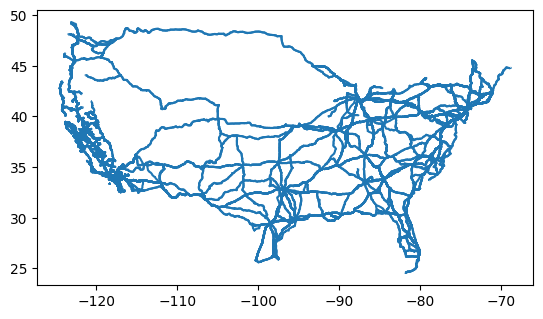

In [156]:
#gdf of all routes, nation wide?

gdf_check(routes)

Dataframe type is = <class 'geopandas.geodataframe.GeoDataFrame'>
gdf shape is = (209, 10)
Active geometry col name is = geometry


,org_id,agency,route_id,route_type,route_name,shape_id,n_trips,base64_url,uri,geometry
0,recKsb5FnJy70up78,Amtrak,36921,2,Empire Service,245,6,aHR0cHM6Ly9jb250ZW50LmFtdHJhay5jb20vY29udGVudC...,https://content.amtrak.com/content/gtfs/GTFS.zip,"LINESTRING (-73.74115 42.64103, -73.74159 42.6..."
1,recKsb5FnJy70up78,Amtrak,36921,2,Empire Service,248,6,aHR0cHM6Ly9jb250ZW50LmFtdHJhay5jb20vY29udGVudC...,https://content.amtrak.com/content/gtfs/GTFS.zip,"LINESTRING (-73.99446 40.75033, -74.00083 40.7..."
2,recKsb5FnJy70up78,Amtrak,36921,2,Empire Service,279,2,aHR0cHM6Ly9jb250ZW50LmFtdHJhay5jb20vY29udGVudC...,https://content.amtrak.com/content/gtfs/GTFS.zip,"LINESTRING (-73.99446 40.75033, -74.00083 40.7..."
3,recKsb5FnJy70up78,Amtrak,36921,2,Empire Service,280,2,aHR0cHM6Ly9jb250ZW50LmFtdHJhay5jb20vY29udGVudC...,https://content.amtrak.com/content/gtfs/GTFS.zip,"LINESTRING (-79.03186 43.11355, -79.03157 43.1..."
4,recKsb5FnJy70up78,Amtrak,36922,2,Capitol Limited,238,1,aHR0cHM6Ly9jb250ZW50LmFtdHJhay5jb20vY29udGVudC...,https://content.amtrak.com/content/gtfs/GTFS.zip,"LINESTRING (-77.00642 38.89699, -76.99970 38.9..."


<AxesSubplot:>

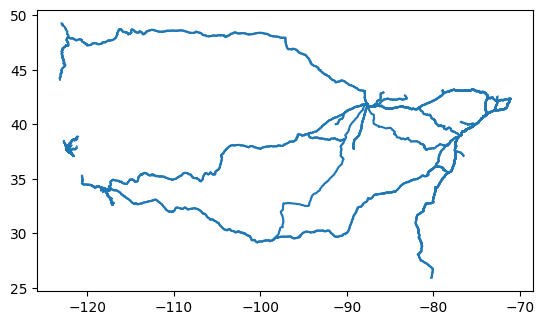

In [157]:
#gdf of all rail routes
gdf_check(rail_routes)

Dataframe type is = <class 'geopandas.geodataframe.GeoDataFrame'>
gdf shape is = (119968, 9)
Active geometry col name is = geometry


,org_id,agency,route_id,route_type,stop_id,stop_name,base64_url,uri,geometry
0,recNaKvzVQhGX1puu,City of Alhambra,BlueLine,3,2619798,Chapel Ave & Bay St,aHR0cHM6Ly9naXRodWIuY29tL0xBQ01UQS9sb3MtYW5nZW...,https://github.com/LACMTA/los-angeles-regional...,POINT (-118.12232 34.09485)
1,recNaKvzVQhGX1puu,City of Alhambra,BlueLine,3,2619799,Chapel Ave & Main St,aHR0cHM6Ly9naXRodWIuY29tL0xBQ01UQS9sb3MtYW5nZW...,https://github.com/LACMTA/los-angeles-regional...,POINT (-118.12338 34.09636)
2,recNaKvzVQhGX1puu,City of Alhambra,BlueLine,3,2619802,Chapel Ave & Woodward Ave,aHR0cHM6Ly9naXRodWIuY29tL0xBQ01UQS9sb3MtYW5nZW...,https://github.com/LACMTA/los-angeles-regional...,POINT (-118.12529 34.09908)
3,recNaKvzVQhGX1puu,City of Alhambra,BlueLine,3,2619804,Woodward Ave & Garfield Ave,aHR0cHM6Ly9naXRodWIuY29tL0xBQ01UQS9sb3MtYW5nZW...,https://github.com/LACMTA/los-angeles-regional...,POINT (-118.12824 34.09790)
4,recNaKvzVQhGX1puu,City of Alhambra,BlueLine,3,2619807,Garfield Ave & Main St,aHR0cHM6Ly9naXRodWIuY29tL0xBQ01UQS9sb3MtYW5nZW...,https://github.com/LACMTA/los-angeles-regional...,POINT (-118.12705 34.09530)


<AxesSubplot:>

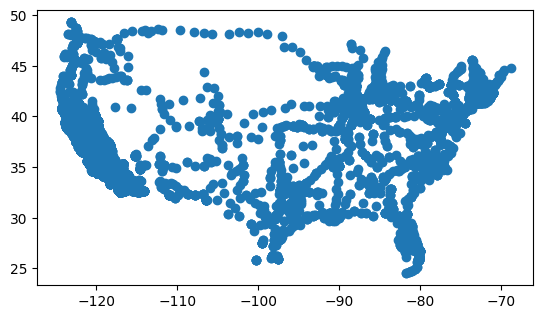

In [158]:
#gdf of all transit stops
gdf_check(stops)

Dataframe type is = <class 'geopandas.geodataframe.GeoDataFrame'>
gdf shape is = (2045, 9)
Active geometry col name is = geometry


,org_id,agency,route_id,route_type,stop_id,stop_name,base64_url,uri,geometry
0,recKsb5FnJy70up78,Amtrak,11317,2,FMT,Fremont,aHR0cHM6Ly9jb250ZW50LmFtdHJhay5jb20vY29udGVudC...,https://content.amtrak.com/content/gtfs/GTFS.zip,POINT (-122.00750 37.55909)
1,recKsb5FnJy70up78,Amtrak,11317,2,GAC,Santa Clara Great America Amtrak,aHR0cHM6Ly9jb250ZW50LmFtdHJhay5jb20vY29udGVudC...,https://content.amtrak.com/content/gtfs/GTFS.zip,POINT (-121.96700 37.40678)
2,recKsb5FnJy70up78,Amtrak,11317,2,LIV,Livermore Amtrak Bus Stop,aHR0cHM6Ly9jb250ZW50LmFtdHJhay5jb20vY29udGVudC...,https://content.amtrak.com/content/gtfs/GTFS.zip,POINT (-121.76712 37.68491)
3,recKsb5FnJy70up78,Amtrak,11317,2,LTM,Lathrop-Manteca Amtrak Station,aHR0cHM6Ly9jb250ZW50LmFtdHJhay5jb20vY29udGVudC...,https://content.amtrak.com/content/gtfs/GTFS.zip,POINT (-121.26366 37.79836)
4,recKsb5FnJy70up78,Amtrak,11317,2,PLS,Pleasanton Amtrak Station,aHR0cHM6Ly9jb250ZW50LmFtdHJhay5jb20vY29udGVudC...,https://content.amtrak.com/content/gtfs/GTFS.zip,POINT (-121.88264 37.65815)


<AxesSubplot:>

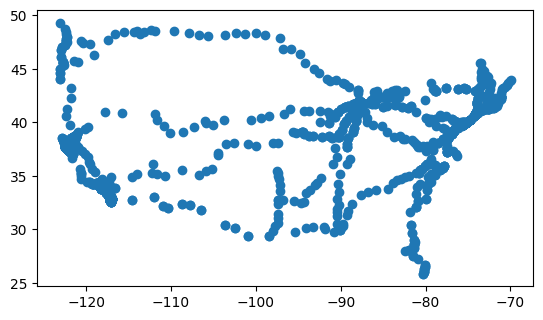

In [159]:
#gdf of all rail stops
gdf_check(rail_stops)

---

## Cleaning

---

In [17]:
# projected CRS to 2229
districts2229 = districts.to_crs('EPSG:2229')
highways2229 = highways.to_crs('EPSG:2229')
routes2229 = routes.to_crs('EPSG:2229')
rail_routes2229 = rail_routes.to_crs('EPSG:2229')
stops2229 = stops.to_crs('EPSG:2229')
rail_stops2229 = rail_stops.to_crs('EPSG:2229')



<AxesSubplot:>

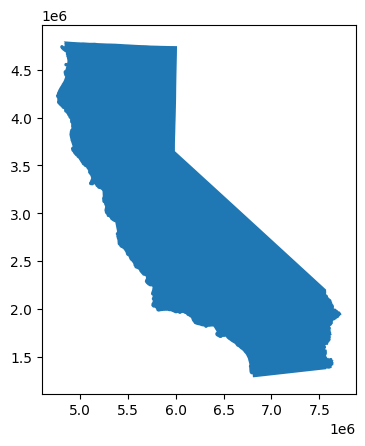

In [18]:
# dissolve district to single CA map
ca = districts2229.dissolve()

ca.plot()

In [38]:
ca

,geometry,OBJECTID,DISTRICT,Region,Shape__Area,Shape__Length
0,"POLYGON ((6105565.229 1946214.162, 6102975.223...",1,1,North,4.659910e+10,1.644579e+06


In [160]:
#What else can i dissolve
#highways2229 = highways.to_crs('EPSG:2229')
#routes2229 = routes.to_crs('EPSG:2229')
#rail_routes2229 = rail_routes.to_crs('EPSG:2229')
#stops2229 = stops.to_crs('EPSG:2229')
#rail_stops2229 = rail_stops.to_crs('EPSG:2229')

highway_d = highways2229.dissolve()
routes_d= routes2229.dissolve()
rail_routes_d= rail_routes2229.dissolve()
stops_d = stops2229.dissolve()
rail_stops_d = rail_stops2229.dissolve()

In [162]:
#dissolve check function

def d_check(x):
    display(x.head()),
    display(x.plot())
    return


,geometry,Route,County,District,RouteType,Direction
0,"MULTILINESTRING ((6518147.781 1746024.206, 651...",1,LA,7,State,NB


<AxesSubplot:>

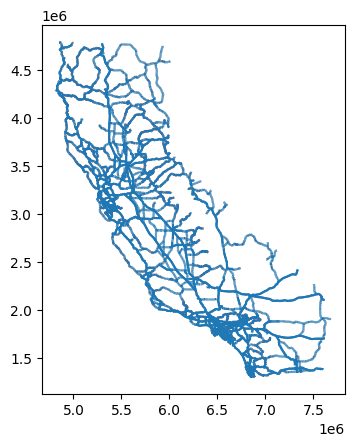

In [163]:
d_check(highway_d)

,geometry,org_id,agency,route_id,route_type,route_name,shape_id,n_trips,base64_url,uri
0,"MULTILINESTRING ((6510673.613 1845455.882, 651...",recNaKvzVQhGX1puu,City of Alhambra,BlueLine,3,Blue Line,p_901543,17,aHR0cHM6Ly9naXRodWIuY29tL0xBQ01UQS9sb3MtYW5nZW...,https://github.com/LACMTA/los-angeles-regional...


<AxesSubplot:>

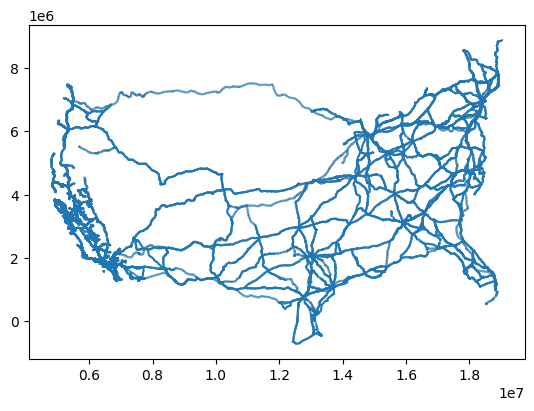

In [164]:
d_check(routes_d)

,geometry,org_id,agency,route_id,route_type,route_name,shape_id,n_trips,base64_url,uri
0,"MULTILINESTRING ((18202138.507 7583327.372, 18...",recKsb5FnJy70up78,Amtrak,36921,2,Empire Service,245,6,aHR0cHM6Ly9jb250ZW50LmFtdHJhay5jb20vY29udGVudC...,https://content.amtrak.com/content/gtfs/GTFS.zip


<AxesSubplot:>

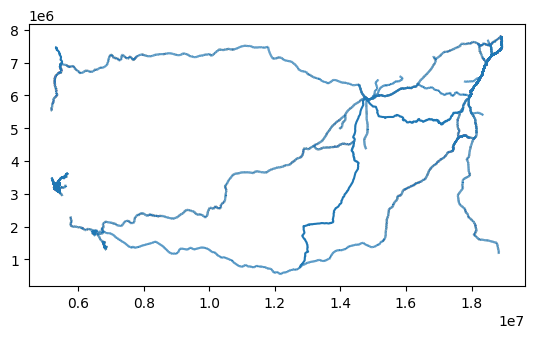

In [165]:
d_check(rail_routes_d)

,geometry,org_id,agency,route_id,route_type,stop_id,stop_name,base64_url,uri
0,"MULTIPOINT (4799952.547 5075711.797, 4812770.9...",recNaKvzVQhGX1puu,City of Alhambra,BlueLine,3,2619798,Chapel Ave & Bay St,aHR0cHM6Ly9naXRodWIuY29tL0xBQ01UQS9sb3MtYW5nZW...,https://github.com/LACMTA/los-angeles-regional...


<AxesSubplot:>

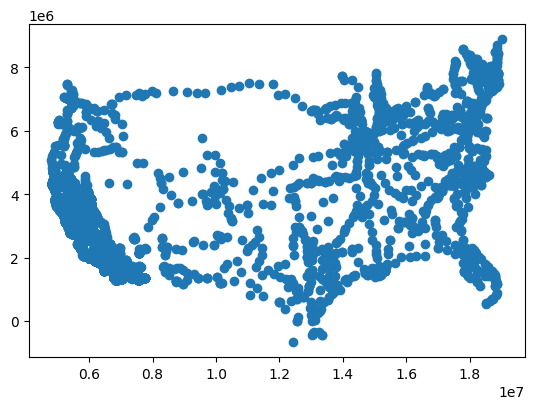

In [166]:
d_check(stops_d)

,geometry,org_id,agency,route_id,route_type,stop_id,stop_name,base64_url,uri
0,"MULTIPOINT (5190305.697 3497711.982, 5190306.7...",recKsb5FnJy70up78,Amtrak,11317,2,FMT,Fremont,aHR0cHM6Ly9jb250ZW50LmFtdHJhay5jb20vY29udGVudC...,https://content.amtrak.com/content/gtfs/GTFS.zip


<AxesSubplot:>

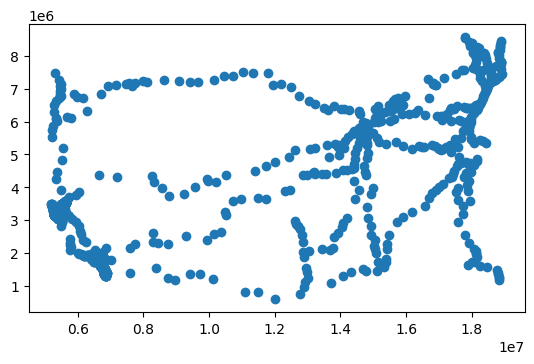

In [167]:
d_check(rail_stops_d)

In [23]:
#clip the remaining gdf to ca map
#1. routes (nationwide)
#2. rail routes (nationwide)
#3. stops 
#4. rail stops
#syntax: gdf.clip(gdf)

ca_routes = routes2229.clip(ca)
ca_rail = rail_routes2229.clip(ca)
ca_stops = stops2229.clip(ca)
ca_rail_stops = rail_stops2229.clip(ca)


In [ ]:
#### TRY DISSOLVING THE ABOVE!!!
### THEN OVERLAY ON STUFF

,org_id,agency,route_id,route_type,route_name,shape_id,n_trips,base64_url,uri,geometry
22,recKsb5FnJy70up78,Amtrak,36930,2,Sunset Limited,269,1,aHR0cHM6Ly9jb250ZW50LmFtdHJhay5jb20vY29udGVudC...,https://content.amtrak.com/content/gtfs/GTFS.zip,"MULTILINESTRING ((7602807.693 1377257.623, 760..."
23,recKsb5FnJy70up78,Amtrak,36930,2,Sunset Limited,271,1,aHR0cHM6Ly9jb250ZW50LmFtdHJhay5jb20vY29udGVudC...,https://content.amtrak.com/content/gtfs/GTFS.zip,"MULTILINESTRING ((6489947.165 1842910.544, 649..."
2848,recLW3EuIHTqTjdds,Greyhound,US1001,3,Phoenix - Houston,c37251529f04a05b2574ce6daa6843b4,1,aHR0cDovL2d0ZnMuZ2lzLmZsaXgudGVjaC9ndGZzX2dlbm...,http://gtfs.gis.flix.tech/gtfs_generic_us.zip,"MULTILINESTRING ((7617963.358 1696760.580, 761..."
2847,recLW3EuIHTqTjdds,Greyhound,US1001,3,Phoenix - Houston,a2bb22ec6b8d212187fa35489ed076a0,1,aHR0cDovL2d0ZnMuZ2lzLmZsaXgudGVjaC9ndGZzX2dlbm...,http://gtfs.gis.flix.tech/gtfs_generic_us.zip,"MULTILINESTRING ((6491323.819 1842508.112, 649..."
5840,rech5YtfjpQvVIBAF,Flagship Cruises and Events Inc.,894,3,Morena/Campo - El Cajon,S2_894_2_33,1,aHR0cHM6Ly93d3cuc2RtdHMuY29tL2dvb2dsZV90cmFuc2...,https://www.sdmts.com/google_transit_files/goo...,"MULTILINESTRING ((6892035.793 1361216.709, 689..."


<AxesSubplot:>

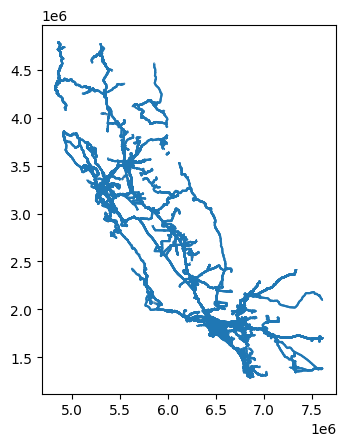

In [168]:
d_check(ca_routes)

,org_id,agency,route_id,route_type,route_name,shape_id,n_trips,base64_url,uri,geometry,length,half_len
167,recPnGkwdpnr8jmHB,Los Angeles County Metropolitan Transportation...,805,1,Metro D-Line,805EB_190513,89,aHR0cHM6Ly9naXRsYWIuY29tL0xBQ01UQS9ndGZzX3JhaW...,https://gitlab.com/LACMTA/gtfs_rail/raw/master...,"LINESTRING (6467811.689 1844958.751, 6467905.8...",31123.925244,15561.962622
168,recPnGkwdpnr8jmHB,Los Angeles County Metropolitan Transportation...,805,1,Metro D-Line,805WB_190513,88,aHR0cHM6Ly9naXRsYWIuY29tL0xBQ01UQS9ndGZzX3JhaW...,https://gitlab.com/LACMTA/gtfs_rail/raw/master...,"LINESTRING (6491361.499 1839175.379, 6491362.1...",31055.748734,15527.874367
161,recPnGkwdpnr8jmHB,Los Angeles County Metropolitan Transportation...,802,1,Metro B-Line,802EB_190513,91,aHR0cHM6Ly9naXRsYWIuY29tL0xBQ01UQS9ndGZzX3JhaW...,https://gitlab.com/LACMTA/gtfs_rail/raw/master...,"LINESTRING (6447247.135 1884754.987, 6447751.8...",82669.990419,41334.995209
162,recPnGkwdpnr8jmHB,Los Angeles County Metropolitan Transportation...,802,1,Metro B-Line,802WB_190513,91,aHR0cHM6Ly9naXRsYWIuY29tL0xBQ01UQS9ndGZzX3JhaW...,https://gitlab.com/LACMTA/gtfs_rail/raw/master...,"LINESTRING (6491361.510 1839175.378, 6491362.2...",82713.058443,41356.529221
147,recC5CT95EufmQCXr,Santa Clara Valley Transportation Authority,BlueS,0,"Due to construction, portions of Light Rail re...",110754,2,aHR0cHM6Ly9hcGkuNTExLm9yZy90cmFuc2l0L2RhdGFmZW...,https://api.511.org/transit/datafeeds?api_key=...,"LINESTRING (5426631.150 3064619.004, 5427824.4...",63525.709800,31762.854900


<AxesSubplot:>

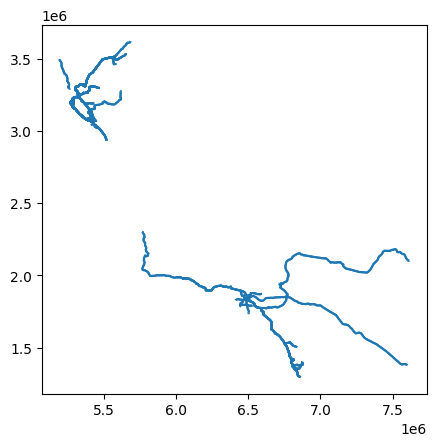

In [169]:
d_check(ca_rail)

,org_id,agency,route_id,route_type,stop_id,stop_name,base64_url,uri,geometry
102103,rech5YtfjpQvVIBAF,Flagship Cruises and Events Inc.,950,3,88963,Otay Mesa Transit Center,aHR0cHM6Ly93d3cuc2RtdHMuY29tL2dvb2dsZV90cmFuc2...,https://www.sdmts.com/google_transit_files/goo...,POINT (6888566.919 1297344.013)
101162,rech5YtfjpQvVIBAF,Flagship Cruises and Events Inc.,909,3,60529,Via De La Amistad & Roll Dr,aHR0cHM6Ly93d3cuc2RtdHMuY29tL2dvb2dsZV90cmFuc2...,https://www.sdmts.com/google_transit_files/goo...,POINT (6889498.731 1297378.021)
101173,rech5YtfjpQvVIBAF,Flagship Cruises and Events Inc.,909,3,88964,Otay Mesa Transit Center,aHR0cHM6Ly93d3cuc2RtdHMuY29tL2dvb2dsZV90cmFuc2...,https://www.sdmts.com/google_transit_files/goo...,POINT (6888510.894 1297383.680)
101065,rech5YtfjpQvVIBAF,Flagship Cruises and Events Inc.,905,3,60523,Siempre Viva Rd & Customhouse Plaza,aHR0cHM6Ly93d3cuc2RtdHMuY29tL2dvb2dsZV90cmFuc2...,https://www.sdmts.com/google_transit_files/goo...,POINT (6886743.534 1297385.771)
101064,rech5YtfjpQvVIBAF,Flagship Cruises and Events Inc.,905,3,60522,Siempre Viva Rd & Drucker Ln,aHR0cHM6Ly93d3cuc2RtdHMuY29tL2dvb2dsZV90cmFuc2...,https://www.sdmts.com/google_transit_files/goo...,POINT (6885821.738 1297391.965)


<AxesSubplot:>

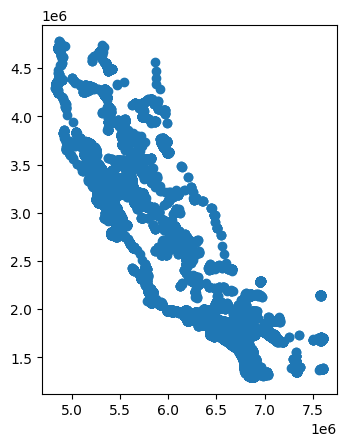

In [170]:
d_check(ca_stops)

,org_id,agency,route_id,route_type,stop_id,stop_name,base64_url,uri,geometry
1537,recPnGkwdpnr8jmHB,Los Angeles County Metropolitan Transportation...,801,0,80102,Pacific Ave Station,aHR0cHM6Ly9naXRsYWIuY29tL0xBQ01UQS9ndGZzX3JhaW...,https://gitlab.com/LACMTA/gtfs_rail/raw/master...,POINT (6502796.262 1739558.050)
1541,recPnGkwdpnr8jmHB,Los Angeles County Metropolitan Transportation...,801,0,80108,Wardlow Station,aHR0cHM6Ly9naXRsYWIuY29tL0xBQ01UQS9ndGZzX3JhaW...,https://gitlab.com/LACMTA/gtfs_rail/raw/master...,POINT (6502103.679 1756884.927)
1542,recPnGkwdpnr8jmHB,Los Angeles County Metropolitan Transportation...,801,0,80109,Del Amo Station,aHR0cHM6Ly9naXRsYWIuY29tL0xBQ01UQS9ndGZzX3JhaW...,https://gitlab.com/LACMTA/gtfs_rail/raw/master...,POINT (6497591.225 1767213.933)
1543,recPnGkwdpnr8jmHB,Los Angeles County Metropolitan Transportation...,801,0,80110,Artesia Station,aHR0cHM6Ly9naXRsYWIuY29tL0xBQ01UQS9ndGZzX3JhaW...,https://gitlab.com/LACMTA/gtfs_rail/raw/master...,POINT (6494125.943 1777360.375)
1544,recPnGkwdpnr8jmHB,Los Angeles County Metropolitan Transportation...,801,0,80111,Compton Station,aHR0cHM6Ly9naXRsYWIuY29tL0xBQ01UQS9ndGZzX3JhaW...,https://gitlab.com/LACMTA/gtfs_rail/raw/master...,POINT (6493613.327 1785152.416)


<AxesSubplot:>

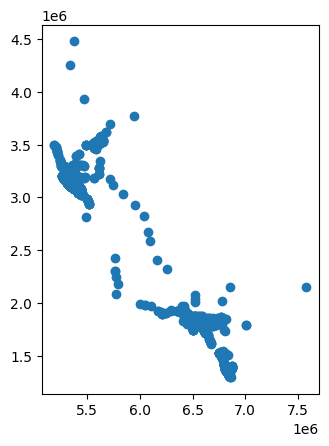

In [171]:
d_check(ca_rail_stops)

---

analysis

---

,org_id,agency,route_id,route_type,route_name,shape_id,n_trips,base64_url,uri,geometry,length,half_len,g_buffer
167,recPnGkwdpnr8jmHB,Los Angeles County Metropolitan Transportation...,805,1,Metro D-Line,805EB_190513,89,aHR0cHM6Ly9naXRsYWIuY29tL0xBQ01UQS9ndGZzX3JhaW...,https://gitlab.com/LACMTA/gtfs_rail/raw/master...,"LINESTRING (6467811.689 1844958.751, 6467905.8...",31123.925244,15561.962622,"POLYGON ((6467900.569 1846279.119, 6468010.695..."
168,recPnGkwdpnr8jmHB,Los Angeles County Metropolitan Transportation...,805,1,Metro D-Line,805WB_190513,88,aHR0cHM6Ly9naXRsYWIuY29tL0xBQ01UQS9ndGZzX3JhaW...,https://gitlab.com/LACMTA/gtfs_rail/raw/master...,"LINESTRING (6491361.499 1839175.379, 6491362.1...",31055.748734,15527.874367,"POLYGON ((6471162.297 1846334.759, 6471168.277..."
161,recPnGkwdpnr8jmHB,Los Angeles County Metropolitan Transportation...,802,1,Metro B-Line,802EB_190513,91,aHR0cHM6Ly9naXRsYWIuY29tL0xBQ01UQS9ndGZzX3JhaW...,https://gitlab.com/LACMTA/gtfs_rail/raw/master...,"LINESTRING (6447247.135 1884754.987, 6447751.8...",82669.990419,41334.995209,"POLYGON ((6448933.329 1884330.766, 6449168.390..."
162,recPnGkwdpnr8jmHB,Los Angeles County Metropolitan Transportation...,802,1,Metro B-Line,802WB_190513,91,aHR0cHM6Ly9naXRsYWIuY29tL0xBQ01UQS9ndGZzX3JhaW...,https://gitlab.com/LACMTA/gtfs_rail/raw/master...,"LINESTRING (6491361.510 1839175.378, 6491362.2...",82713.058443,41356.529221,"POLYGON ((6452950.740 1871989.509, 6452949.298..."
147,recC5CT95EufmQCXr,Santa Clara Valley Transportation Authority,BlueS,0,"Due to construction, portions of Light Rail re...",110754,2,aHR0cHM6Ly9hcGkuNTExLm9yZy90cmFuc2l0L2RhdGFmZW...,https://api.511.org/transit/datafeeds?api_key=...,"LINESTRING (5426631.150 3064619.004, 5427824.4...",63525.709800,31762.854900,"POLYGON ((5427478.397 3055391.367, 5427457.482..."


'geometry'

<AxesSubplot:>

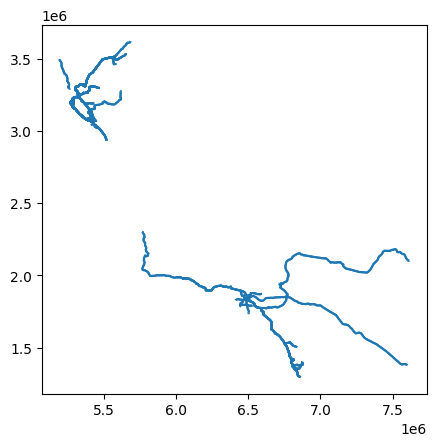

In [109]:
# buffering the rail route to 1320 ft.

ca_rail_buffer = ca_rail.assign(g_buffer = ca_rail.geometry.buffer(1320))

display(ca_rail_buffer.head())
display(ca_rail_buffer.geometry.name)
ca_rail_buffer.plot()

<AxesSubplot:>

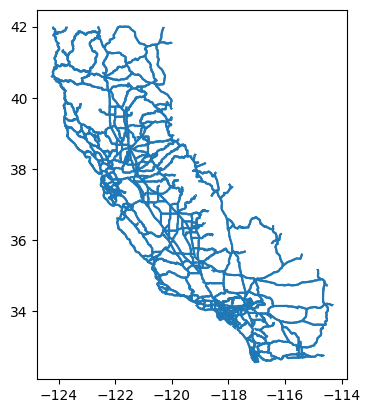

In [47]:
ca_highways.plot()

In [45]:
# add new col for length and half-legth of rail route from ca_rail
# may need this later to update buffer
ca_rail = ca_rail.assign(length = ca_rail.geometry.length)
ca_rail.head()

,org_id,agency,route_id,route_type,route_name,shape_id,n_trips,base64_url,uri,geometry,length,half_len
167,recPnGkwdpnr8jmHB,Los Angeles County Metropolitan Transportation...,805,1,Metro D-Line,805EB_190513,89,aHR0cHM6Ly9naXRsYWIuY29tL0xBQ01UQS9ndGZzX3JhaW...,https://gitlab.com/LACMTA/gtfs_rail/raw/master...,"LINESTRING (6467811.689 1844958.751, 6467905.8...",31123.925244,15561.962622
168,recPnGkwdpnr8jmHB,Los Angeles County Metropolitan Transportation...,805,1,Metro D-Line,805WB_190513,88,aHR0cHM6Ly9naXRsYWIuY29tL0xBQ01UQS9ndGZzX3JhaW...,https://gitlab.com/LACMTA/gtfs_rail/raw/master...,"LINESTRING (6491361.499 1839175.379, 6491362.1...",31055.748734,15527.874367
161,recPnGkwdpnr8jmHB,Los Angeles County Metropolitan Transportation...,802,1,Metro B-Line,802EB_190513,91,aHR0cHM6Ly9naXRsYWIuY29tL0xBQ01UQS9ndGZzX3JhaW...,https://gitlab.com/LACMTA/gtfs_rail/raw/master...,"LINESTRING (6447247.135 1884754.987, 6447751.8...",82669.990419,41334.995209
162,recPnGkwdpnr8jmHB,Los Angeles County Metropolitan Transportation...,802,1,Metro B-Line,802WB_190513,91,aHR0cHM6Ly9naXRsYWIuY29tL0xBQ01UQS9ndGZzX3JhaW...,https://gitlab.com/LACMTA/gtfs_rail/raw/master...,"LINESTRING (6491361.510 1839175.378, 6491362.2...",82713.058443,41356.529221
147,recC5CT95EufmQCXr,Santa Clara Valley Transportation Authority,BlueS,0,"Due to construction, portions of Light Rail re...",110754,2,aHR0cHM6Ly9hcGkuNTExLm9yZy90cmFuc2l0L2RhdGFmZW...,https://api.511.org/transit/datafeeds?api_key=...,"LINESTRING (5426631.150 3064619.004, 5427824.4...",63525.709800,31762.854900


In [127]:
#Test of overlay districts and ca_rail_buffer 

overlay = gpd.overlay(
    districts2229,
    ca_rail_buffer.set_geometry('g_buffer'),
    how = 'difference',
    keep_geom_type=True
)


In [120]:
districts2229

,OBJECTID,DISTRICT,Region,Shape__Area,Shape__Length,geometry
0,1,1,North,4.659910e+10,1.644579e+06,"POLYGON ((5050292.349 4784444.908, 5050260.600..."
1,2,2,North,1.266950e+11,1.775639e+06,"POLYGON ((5382628.905 4770985.627, 5371797.907..."
2,3,3,North,5.458748e+10,1.468290e+06,"POLYGON ((5605540.574 4073307.906, 5605545.151..."
3,4,4,,3.383387e+10,1.291122e+06,"POLYGON ((5308833.259 3618920.240, 5308774.452..."
4,5,5,Central,4.853090e+10,1.380598e+06,"POLYGON ((5622090.455 2914919.212, 5620633.501..."
5,6,6,Central,7.771129e+10,1.470658e+06,"POLYGON ((6185270.086 3197143.158, 6185195.089..."
6,7,8,,1.049175e+11,1.365594e+06,"POLYGON ((7259072.263 2488995.558, 7259016.566..."
7,8,10,Central,4.591324e+10,1.205887e+06,"POLYGON ((6107875.767 3543252.376, 6102131.628..."
8,9,11,,3.328689e+10,9.262555e+05,"POLYGON ((6745216.033 1642904.220, 6739936.006..."
9,10,7,,2.358705e+10,7.143839e+05,"POLYGON ((6178430.583 2141154.173, 6178458.776..."


In [115]:
ca_rail_buffer.head(2)

,org_id,agency,route_id,route_type,route_name,shape_id,n_trips,base64_url,uri,geometry,length,half_len,g_buffer
167,recPnGkwdpnr8jmHB,Los Angeles County Metropolitan Transportation...,805,1,Metro D-Line,805EB_190513,89,aHR0cHM6Ly9naXRsYWIuY29tL0xBQ01UQS9ndGZzX3JhaW...,https://gitlab.com/LACMTA/gtfs_rail/raw/master...,"LINESTRING (6467811.689 1844958.751, 6467905.8...",31123.925244,15561.962622,"POLYGON ((6467900.569 1846279.119, 6468010.695..."
168,recPnGkwdpnr8jmHB,Los Angeles County Metropolitan Transportation...,805,1,Metro D-Line,805WB_190513,88,aHR0cHM6Ly9naXRsYWIuY29tL0xBQ01UQS9ndGZzX3JhaW...,https://gitlab.com/LACMTA/gtfs_rail/raw/master...,"LINESTRING (6491361.499 1839175.379, 6491362.1...",31055.748734,15527.874367,"POLYGON ((6471162.297 1846334.759, 6471168.277..."


,OBJECTID,DISTRICT,Region,Shape__Area,Shape__Length,geometry
0,1,1,North,4.659910e+10,1.644579e+06,"POLYGON ((5050292.349 4784444.908, 5050268.281..."
1,2,2,North,1.266950e+11,1.775639e+06,"POLYGON ((5382628.905 4770985.627, 5388623.509..."
2,3,3,North,5.458748e+10,1.468290e+06,"MULTIPOLYGON (((5482363.295 3491142.734, 54822..."
3,4,4,,3.383387e+10,1.291122e+06,"MULTIPOLYGON (((5317388.087 3612326.627, 53174..."
4,5,5,Central,4.853090e+10,1.380598e+06,"POLYGON ((6115921.461 1961034.606, 6115902.684..."
5,6,6,Central,7.771129e+10,1.470658e+06,"POLYGON ((6185270.086 3197143.158, 6185445.784..."
6,7,8,,1.049175e+11,1.365594e+06,"MULTIPOLYGON (((7617794.107 2101167.829, 76179..."
7,8,10,Central,4.591324e+10,1.205887e+06,"POLYGON ((5531696.435 3196048.990, 5531758.251..."
8,9,11,,3.328689e+10,9.262555e+05,"MULTIPOLYGON (((7413822.444 1626323.207, 74282..."
9,10,7,,2.358705e+10,7.143839e+05,"MULTIPOLYGON (((6261230.660 2119511.893, 62624..."


'geometry'

<AxesSubplot:>

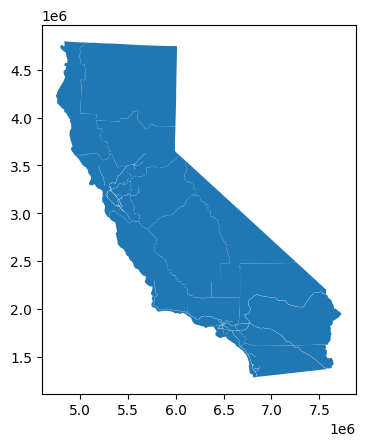

In [128]:
#got something when i overlay districts and rail routes!

#inspect what happens to the geometry column after overlaying. are there any duplicate rows? if so, why.
#are the routes the same after the overlay?
#remember to use length, and % of something. 
# 
display(overlay)
display(overlay.geometry.name)
overlay.plot()

In [91]:
import matplotlib.pyplot as plt



In [129]:
#try dissolving highways2999.
#overlay changes geometry values.
#try overlay to get length of rail route that interects
#try to find difference of overlayed geomety from SHN
highways2229

,Route,County,District,RouteType,Direction,geometry
0,1,LA,7,State,NB,"MULTILINESTRING ((6518147.781 1746024.206, 651..."
1,1,LA,7,State,SB,"MULTILINESTRING ((6441469.111 1802436.519, 644..."
2,1,MEN,1,State,NB,"MULTILINESTRING ((4921021.829 3983216.471, 492..."
3,1,MEN,1,State,SB,"MULTILINESTRING ((4925456.388 3944268.826, 492..."
4,1,MON,5,State,NB,"MULTILINESTRING ((5458132.055 2852112.660, 545..."


<AxesSubplot:>

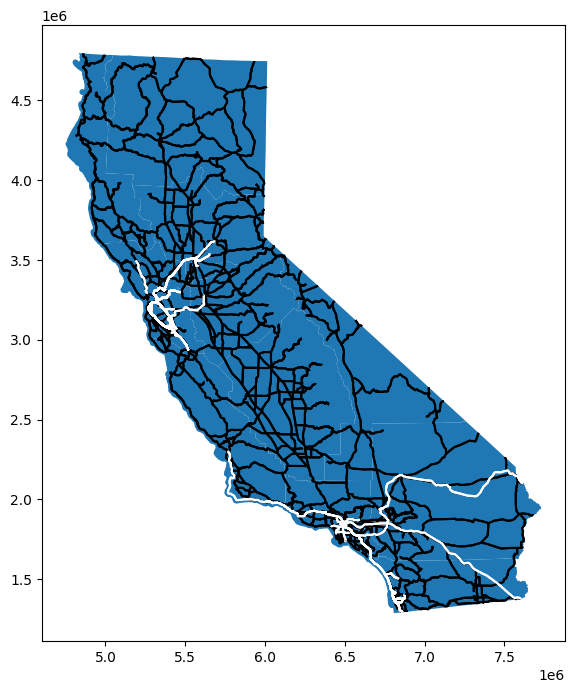

In [98]:
#found this via youtube tutorial.
#maps the highways and rail routes over distrcts

fig, ax = plt.subplots(figsize = (10,8))
highways2229.plot(ax = ax, edgecolor = 'black')
ca_rail_buffer.plot(ax= ax, edgecolor = 'white')
districts2229.plot(ax = ax)